In [7]:
!pip3 install wordcloud

In [9]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import string

# Libraries for nlp
import re
import wordninja 
from textblob import Word
from nltk.corpus import stopwords
from textblob import TextBlob

import matplotlib.pyplot as plt
from wordcloud import WordCloud



In [ ]:
df =  pd.read_csv('tweet1k')
df.head()

,Datetime,Tweet Id,Text,Username,LikeCount
0,2022-12-14 23:47:00+00:00,1603174748451733504,Ditto @Safaricom_Care https://t.co/SgK6L3YQhd,OnguruMeister,0
1,2022-12-14 23:41:18+00:00,1603173313052037120,"@ital_john Hello John, the deadline was Octobe...",Safaricom_Care,0
2,2022-12-14 23:35:29+00:00,1603171849428508673,@missy_k32 @AbdulahiAdan10 @Safaricom_Care @be...,I_im_kibagendi,0
3,2022-12-14 23:34:57+00:00,1603171716594692096,"@Safaricom_Care, @SafaricomPLC we demand you ...",MutonyeMutuku_,3
4,2022-12-14 23:19:59+00:00,1603167951682764800,"Hey @Safaricom_Care @SafaricomPLC ,15th Decemb...",ndungujosephn,0


In [ ]:
#change the case of tweets to lower
df['Text'] = df['Text'].str.lower()

In [11]:
# Defining functions to clean data
def remove_links(tweet):
    """Takes in a string and removes weblinks from it"""

    tweet = re.sub(r"https\S+"," ",tweet) 
    tweet = re.sub(r"bit.ly/\S+", " ",tweet)
    return tweet

def remove_user(tweet):
    """Takes in a string and removes @user information from it"""
    tweet = re.sub('(rt\s@[a-z]+[a-z0-9-_]+)', '',tweet)
    tweet = re.sub('(@[a-z]+[a-z0-9-_]+)', '',tweet)
    # tweet = re.sub("(sxsw)"," ",tweet)
    # tweet = re.sub("(link)"," ",tweet)
    return tweet

def deEmojify(text):
    """Takes in text and removes any emoticons"""
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def remove_hasgtags(tweet):
    """Takes in a string and removes @user information from it"""
    tweeet = re.sub('(#[a-z]+[a-z0-9-_]+)', '',tweet)
    return tweet

def basic_clean(tweet):
    """Returns cleaned data, remove punctuation and numbers"""

    tweet = remove_user(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hasgtags(tweet)
    tweet = re.sub('['+ string.punctuation+ ']+', '',tweet) # Removes punctuation
    #tweet = re.sub('([0-9]+)'," ",tweet) # Removes numbers
    return tweet
    

In [ ]:
# Perform the basic clean on all the tweets in our dataframe
res = []
for tweets in df["Text"]:
    res.append(basic_clean(tweets))
df["Clean_Tweets"] = res


In [ ]:
# Remove stop words 
stopwords = stopwords.words('english')
stopwords.extend(["link"])
df["Clean_Tweets"] = df.Clean_Tweets.apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

In [ ]:
# Splitting concatenated words into separate words 
df["Clean_Tweets"] = df.Clean_Tweets.apply(lambda x: wordninja.split(str(TextBlob(x))))  
df["Clean_Tweets"] = df.Clean_Tweets.str.join(' ')
df["Clean_Tweets"].head() 

0                                                ditto
1    hello john deadline october 15 th 2022 still u...
2    see started clearly show boy child misses fund...
3    demand issue statement concerning maxine wa ho...
4    hey 15 th december birthday see today please s...
Name: Clean_Tweets, dtype: object

In [ ]:
# Finding Most Frequent Words i.e. Below are top 10
freq = pd.Series(' '.join(df.Clean_Tweets).split()).value_counts()[:10]
freq

a         982
dm        783
number    638
check     569
kindly    503
hi        496
please    478
hello     473
i         435
s         402
dtype: int64

In [ ]:
# Remove words that have less than 3 letters
df["Clean_Tweets"] = df.Clean_Tweets.apply(lambda x: " ".join(x for x in x.split() if not (len(x)<2)))

In [ ]:
# Finding Most Frequent Words i.e. Below are top 10
freq = pd.Series(' '.join(df.Clean_Tweets).split()).value_counts()[:20]
freq

dm           783
number       638
check        569
kindly       503
hi           496
please       478
hello        473
mp           367
esa          366
com          233
safari       221
us           197
sorry        191
apologies    183
na           178
money        178
issue        177
id           170
share        168
account      166
dtype: int64

In [ ]:
df.Clean_Tweets.str.contains('esa').value_counts()

False    3669
True      332
Name: Clean_Tweets, dtype: int64

In [ ]:
df[df['LikeCount'] == 'Mpesa']

,Datetime,Tweet Id,Text,Username,LikeCount,Clean_Tweets


In [ ]:
df.Clean_Tweets

0                                                   ditto
1       hello john deadline october 15 th 2022 still u...
2       see started clearly show boy child misses fund...
3       demand issue statement concerning maxine wa ho...
4       hey 15 th december birthday see today please s...
                              ...                        
3996                              in hue lew hap shu ally
3997    hi had rack sorry hear that dm number follow t...
3998                   hello there how may help please po
3999                                   hi please check dm
4000                                             check dm
Name: Clean_Tweets, Length: 4001, dtype: object

In [ ]:
mpesa = {"pesa", "m-pesa", "esa", "send money",'fuliza','lipa'}
airtime = {"credit", "card","credit", "airtime"}
fiber ={"home fiber", "fiba", "safaricon home"}


def label_tweet(tweet):
    if mpesa.intersection(tweet.split(" ")):
        return "mpesa"
    elif airtime.intersection(tweet.split(" ")):
        return "credit"
    elif fiber.intersection(tweet.split(" ")):
        return "fiber"

    else:
        return "general"


# Add a new column to the dataframe with the labels for each tweet
df["label"] = df.Clean_Tweets.apply(label_tweet)



In [ ]:
df.label.value_counts()

general    3575
mpesa       330
credit       96
Name: label, dtype: int64

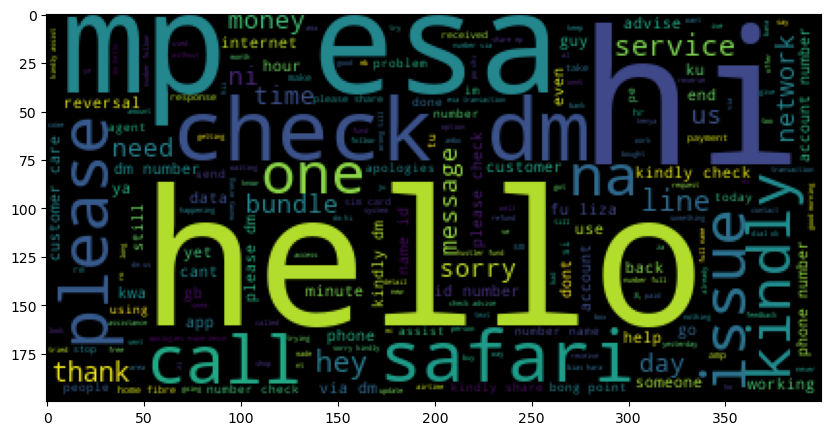

In [ ]:
sentences = df['Clean_Tweets'].tolist()
sentences_ss = " ".join(sentences)

plt.figure(figsize=(10,10))
# plt.imshow(WordCloud(background_color='white',mask=twitter_mask).generate(sentences_ss))
plt.imshow(WordCloud().generate(sentences_ss))